<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw2/blob/main/nndl_2020__homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

#################################################################

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import torchvision

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda



# Dataset






get notMNIST dataset from repo
It is the small version

In [3]:
! git clone https://github.com/DanieleFoscarin/NNDL_hw2.git

Cloning into 'NNDL_hw2'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 51 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [4]:
! tar xzf  /content/NNDL_hw2/notMNIST_small.tar.gz

In [5]:
ROOT = '/content/notMNIST_small' 
from pathlib import Path
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

images = []
labels = []

#there are few broken files that cannot be read
#not a big problem since they are 5 over 500k
num_label = 0
for folder in sorted(Path(ROOT).iterdir()):
  print(folder)
  for f in folder.iterdir():
    try:     
      img = Image.open(f)
      img_array = np.asarray(img)
      images.append(img_array)
      labels.append(num_label)
    except:
      print("a file was not recognized")
  num_label+=1


images_arr = np.float32(np.array(images))
labels_arr = np.float32(np.array(labels))

#free up some memory
del images

# #split dataset for classification purposes if needed
# X_train, X_test, y_train, y_test = train_test_split(images_arr, labels_arr, test_size=0.10, random_state=42)

# print(np.shape(X_train),' ', np.shape(y_train),' ', np.shape(X_test),' ', np.shape(y_test))

/content/notMNIST_small/A
a file was not recognized
/content/notMNIST_small/B
/content/notMNIST_small/C
/content/notMNIST_small/D
/content/notMNIST_small/E
/content/notMNIST_small/F
a file was not recognized
/content/notMNIST_small/G
/content/notMNIST_small/H
/content/notMNIST_small/I
/content/notMNIST_small/J


Dictionary for easy interpreation of the labels

In [6]:
letter = {0: 'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}
# print(letter[6])

In [7]:
#not sure the transformation is done correctly
class NMDataset(Dataset):

    def __init__(self, image, label, transform=None):
        self.transform = transform
        self.image = image
        self.label = label

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        #return a nparray from the dataframe
        this_image = self.image[idx]
        this_label = self.label[idx]
        sample = [this_image, this_label]
        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample


    class ToTensor(object):
        """Convert sample to Tensors."""

        def __call__(self, sample):
            x, y = sample
            return (torch.tensor([x]).float(),
                    torch.tensor([y]).float())

to_tensor = torchvision.transforms.ToTensor()   
# composed_transform = transforms.Compose([ToTensor()])
dataset = NMDataset(images_arr, labels_arr, transform=to_tensor)

#check correctness
out = dataset.__getitem__(0)
print(labels_arr[0])
print(out[1])

0.0
0.0


Split dataset in train, validation, test

In [8]:
length = dataset.__len__()
testval_size = int(np.ceil(length*0.4))
train_size = int(length-testval_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, testval_size])

test_size = int(np.ceil(test_dataset.__len__()*0.5))
val_size = int(test_dataset.__len__()-test_size)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

print(f"train_dataset length {train_dataset.__len__()}")
print(f"val_dataset length {val_dataset.__len__()}")
print(f"test_dataset length {test_dataset.__len__()}")
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset length 11234
val_dataset length 3745
test_dataset length 3745


It works with mnist mmmmh

In [33]:
#just to check database functions
# to_tensor = torchvision.transforms.ToTensor()
# data_dir = 'dataset'
# train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=to_tensor)
# test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=to_tensor)

Show example of the dataset

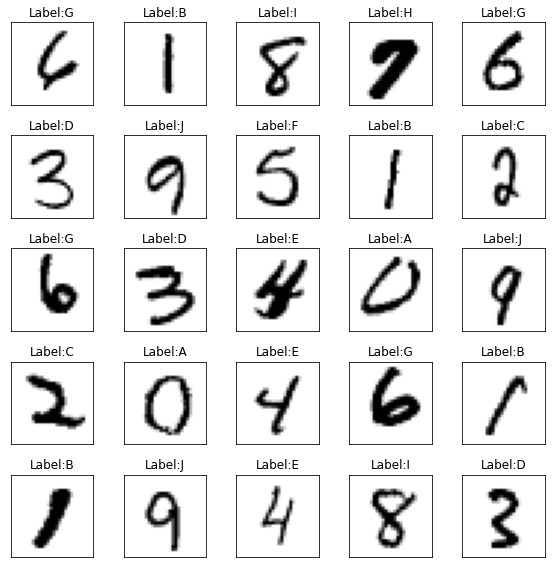

In [34]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(test_dataset)
    img = img.numpy().squeeze()
    ax.imshow(np.array(img), cmap='gray_r')
    ax.set_title(f'Label:{letter[label]}' )
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Autoencoder Model Classes

same as the lab for now

In [11]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [12]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# Training preparation

need to make grid search here

In [35]:
batch_size = 256    #it will be integrated in grid search

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [36]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 6
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [37]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

function for a single epoch training

In [38]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))

function for a single epoch inference

In [39]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [40]:

# img, label = test_dataset[0]
# print(np.shape(img))
# print(letter[label])

Training loop

EPOCH 1/40
	 partial train loss (single batch): 0.174355
	 partial train loss (single batch): 0.173671
	 partial train loss (single batch): 0.172892
	 partial train loss (single batch): 0.172574
	 partial train loss (single batch): 0.172315
	 partial train loss (single batch): 0.172637
	 partial train loss (single batch): 0.171603
	 partial train loss (single batch): 0.171674
	 partial train loss (single batch): 0.171418
	 partial train loss (single batch): 0.170392
	 partial train loss (single batch): 0.169956
	 partial train loss (single batch): 0.169464
	 partial train loss (single batch): 0.169256
	 partial train loss (single batch): 0.168945
	 partial train loss (single batch): 0.168331
	 partial train loss (single batch): 0.168234
	 partial train loss (single batch): 0.167610
	 partial train loss (single batch): 0.167070
	 partial train loss (single batch): 0.166796
	 partial train loss (single batch): 0.166088
	 partial train loss (single batch): 0.164921
	 partial train loss (s

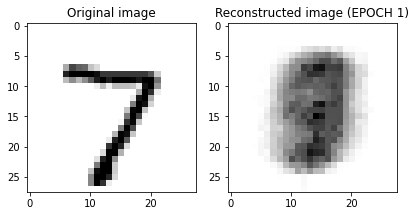

EPOCH 2/40
	 partial train loss (single batch): 0.065477
	 partial train loss (single batch): 0.064244
	 partial train loss (single batch): 0.065398
	 partial train loss (single batch): 0.067696
	 partial train loss (single batch): 0.065010
	 partial train loss (single batch): 0.065304
	 partial train loss (single batch): 0.065343
	 partial train loss (single batch): 0.066190
	 partial train loss (single batch): 0.066097
	 partial train loss (single batch): 0.062595
	 partial train loss (single batch): 0.066084
	 partial train loss (single batch): 0.064543
	 partial train loss (single batch): 0.064898
	 partial train loss (single batch): 0.065011
	 partial train loss (single batch): 0.063703
	 partial train loss (single batch): 0.064751
	 partial train loss (single batch): 0.062624
	 partial train loss (single batch): 0.064047
	 partial train loss (single batch): 0.062630
	 partial train loss (single batch): 0.063619
	 partial train loss (single batch): 0.064285
	 partial train loss (s

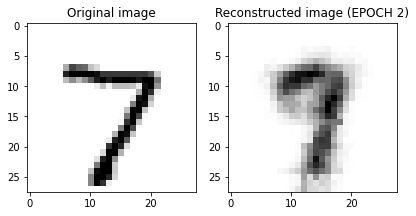

EPOCH 3/40
	 partial train loss (single batch): 0.047403
	 partial train loss (single batch): 0.049167
	 partial train loss (single batch): 0.048354
	 partial train loss (single batch): 0.047808
	 partial train loss (single batch): 0.047818
	 partial train loss (single batch): 0.046612
	 partial train loss (single batch): 0.047353
	 partial train loss (single batch): 0.047534
	 partial train loss (single batch): 0.047274
	 partial train loss (single batch): 0.046629
	 partial train loss (single batch): 0.048391
	 partial train loss (single batch): 0.046539
	 partial train loss (single batch): 0.047131
	 partial train loss (single batch): 0.047793
	 partial train loss (single batch): 0.047462
	 partial train loss (single batch): 0.046914
	 partial train loss (single batch): 0.047136
	 partial train loss (single batch): 0.046613
	 partial train loss (single batch): 0.047420
	 partial train loss (single batch): 0.049310
	 partial train loss (single batch): 0.046652
	 partial train loss (s

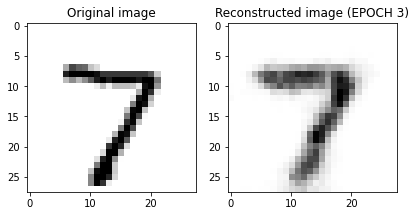

EPOCH 4/40
	 partial train loss (single batch): 0.035913
	 partial train loss (single batch): 0.036561
	 partial train loss (single batch): 0.036584
	 partial train loss (single batch): 0.036674
	 partial train loss (single batch): 0.034362
	 partial train loss (single batch): 0.037724
	 partial train loss (single batch): 0.037908
	 partial train loss (single batch): 0.036011
	 partial train loss (single batch): 0.038782
	 partial train loss (single batch): 0.036520
	 partial train loss (single batch): 0.035951
	 partial train loss (single batch): 0.037332
	 partial train loss (single batch): 0.035101
	 partial train loss (single batch): 0.036378
	 partial train loss (single batch): 0.035667
	 partial train loss (single batch): 0.037403
	 partial train loss (single batch): 0.035789
	 partial train loss (single batch): 0.036935
	 partial train loss (single batch): 0.037684
	 partial train loss (single batch): 0.036137
	 partial train loss (single batch): 0.037041
	 partial train loss (s

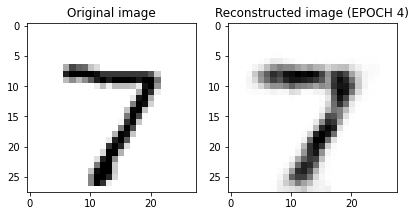

EPOCH 5/40
	 partial train loss (single batch): 0.030991
	 partial train loss (single batch): 0.032688
	 partial train loss (single batch): 0.032228
	 partial train loss (single batch): 0.034140
	 partial train loss (single batch): 0.031982
	 partial train loss (single batch): 0.032018
	 partial train loss (single batch): 0.032918
	 partial train loss (single batch): 0.031889
	 partial train loss (single batch): 0.031900
	 partial train loss (single batch): 0.031572
	 partial train loss (single batch): 0.030439
	 partial train loss (single batch): 0.034003
	 partial train loss (single batch): 0.031281
	 partial train loss (single batch): 0.031267
	 partial train loss (single batch): 0.030662
	 partial train loss (single batch): 0.031348
	 partial train loss (single batch): 0.029800
	 partial train loss (single batch): 0.030029
	 partial train loss (single batch): 0.032741
	 partial train loss (single batch): 0.032202
	 partial train loss (single batch): 0.030779
	 partial train loss (s

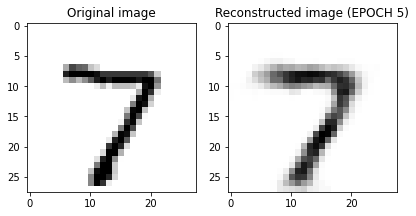

EPOCH 6/40
	 partial train loss (single batch): 0.028552
	 partial train loss (single batch): 0.028369
	 partial train loss (single batch): 0.029823
	 partial train loss (single batch): 0.029327
	 partial train loss (single batch): 0.027034
	 partial train loss (single batch): 0.029208
	 partial train loss (single batch): 0.029932
	 partial train loss (single batch): 0.028717
	 partial train loss (single batch): 0.030719
	 partial train loss (single batch): 0.030019
	 partial train loss (single batch): 0.028160
	 partial train loss (single batch): 0.028628
	 partial train loss (single batch): 0.028681
	 partial train loss (single batch): 0.029710
	 partial train loss (single batch): 0.028470
	 partial train loss (single batch): 0.030625
	 partial train loss (single batch): 0.029069
	 partial train loss (single batch): 0.027903
	 partial train loss (single batch): 0.030636
	 partial train loss (single batch): 0.029342
	 partial train loss (single batch): 0.028970
	 partial train loss (s

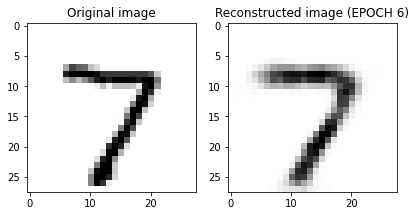

EPOCH 7/40
	 partial train loss (single batch): 0.029568
	 partial train loss (single batch): 0.026616
	 partial train loss (single batch): 0.027615
	 partial train loss (single batch): 0.027584
	 partial train loss (single batch): 0.028557
	 partial train loss (single batch): 0.028430
	 partial train loss (single batch): 0.028025
	 partial train loss (single batch): 0.028112
	 partial train loss (single batch): 0.028142
	 partial train loss (single batch): 0.028295
	 partial train loss (single batch): 0.029331
	 partial train loss (single batch): 0.027513
	 partial train loss (single batch): 0.027028
	 partial train loss (single batch): 0.027518
	 partial train loss (single batch): 0.026691
	 partial train loss (single batch): 0.028088
	 partial train loss (single batch): 0.027373
	 partial train loss (single batch): 0.028276
	 partial train loss (single batch): 0.028506
	 partial train loss (single batch): 0.027583
	 partial train loss (single batch): 0.027739
	 partial train loss (s

KeyboardInterrupt: ignored

In [41]:
### Training cycle
num_epochs = 40
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training